In [5]:
import pymc3 as pm
import theano
import theano.tensor as tt
import numpy as np
import pandas as pd
import arviz as az

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white', {'axes.linewidth': 0.5})
sns.set(style='white', font_scale=1.1,
        rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
            'text.usetex': False, 'font.family': 'serif', 'font.serif': ['Verdana'],
            'text.latex.preamble': r"\usepackage{type1cm}"}) 
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

func_dict = {"mean": np.mean, "q2.5": lambda x: np.percentile(x, 2.5), "q97.5": lambda x: np.percentile(x, 97.5)}

!mkdir -p ../../results

In [6]:
from scipy.integrate import quad

class Integrate(theano.Op):
    def __init__(self, expr, var, *extra_vars):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = extra_vars
        self._func = theano.function(
            [var] + list(extra_vars),
            self._expr,
            on_unused_input='ignore')
    
    def make_node(self, start, stop, *extra_vars):
        self._extra_vars_node = extra_vars
        assert len(self._extra_vars) == len(extra_vars)
        self._start = start
        self._stop = stop
        vars = [start, stop] + list(extra_vars)
        return theano.Apply(self, vars, [tt.dscalar().type()])
    
    def perform(self, node, inputs, out):
        start, stop, *args = inputs
        val = quad(self._func, start, stop, args=tuple(args))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        start, stop, *args = inputs
        out, = grads
        replace = dict(zip(self._extra_vars, args))
        
        replace_ = replace.copy()
        replace_[self._var] = start
        dstart = out * theano.clone(-self._expr, replace=replace_)
        
        replace_ = replace.copy()
        replace_[self._var] = stop
        dstop = out * theano.clone(self._expr, replace=replace_)

        grads = tt.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, *self._extra_vars)
            darg = out * integrate(start, stop, *args)
            dargs.append(darg)
            
        return [dstart, dstop] + dargs

# Data

In [7]:
df = pd.read_csv("../../data/data.csv")
df[-10:]

,date,time,reported,deaths,exports,prob_travel,prob_HN,popWuhan
37,2020-01-15,38,41,2,1,0.003566,0.000025,11081000
38,2020-01-16,39,45,2,2,0.003566,0.000025,11081000
39,2020-01-17,40,62,2,3,0.003566,0.000025,11081000
40,2020-01-18,41,121,3,3,0.003566,0.000025,11081000
41,2020-01-19,42,198,4,3,0.003566,0.000025,11081000
42,2020-01-20,43,291,7,4,0.003566,0.000025,11081000
43,2020-01-21,44,440,18,6,0.003566,0.000025,11081000
44,2020-01-22,45,571,24,8,0.003566,0.000025,11081000
45,2020-01-23,46,830,34,11,0.003566,0.000025,11081000
46,2020-01-24,47,1118,41,20,0.003566,0.000025,11081000


In [8]:
df_onset2death = pd.read_csv("../../data/data_onset2death.csv")
df_onset2death.dist.values

array([20, 15,  6, 10, 14, 41, 12, 30,  7, 19, 13, 10, 11, 19, 16, 17, 24,
        8, 12,  8,  6, 12, 13, 16, 11, 12, 21, 10, 11, 11, 14, 32, 18, 13])

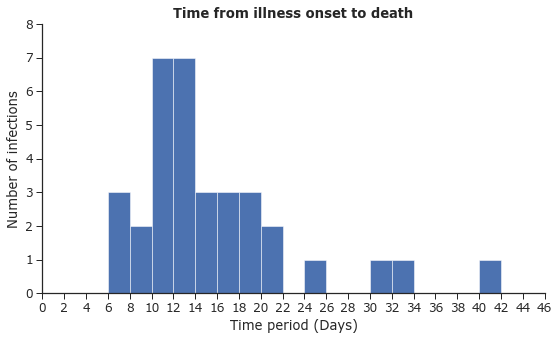

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(9,5.5); 

bins_number = (max(df_onset2death.dist)+2)/2
n, edges = np.histogram(df_onset2death.dist.values, bins=24, range=(0,48), density=False)
timepoints = edges[:-1]
ymax = int(max(n))+1

ax.bar(timepoints, n, lw = 0.5, width = edges[1:]-edges[:-1], edgecolor = 'w', align='edge')
xstep = 2
xtks = edges[:-1]
ax.set_xlim(0,max(xtks))
ax.set_ylim(top=ymax)
ax.set_xticks(xtks)
ax.set_xticklabels([int(x) for x in xtks])
ax.set_xlabel('Time period (Days)'); ax.set_ylabel('Number of infections'); 
ax.set_title('Time from illness onset to death',fontweight='bold')
fig.autofmt_xdate(rotation=0,ha='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

In [10]:
df_onset2report = pd.read_csv("../../data/data_onset2report.csv")
df_onset2report.dist.values

array([13,  8,  2,  6,  6,  3, 10,  2, 14,  3,  1,  2,  8,  2,  6,  2,  5,
        1,  1,  2,  4, 10,  1,  4,  3,  2,  4,  4,  4, 14,  3,  6,  4,  7,
       10,  9,  5,  5,  8,  6,  7, 11,  7,  9,  8, 19, 12, 12, 12, 16, 12])

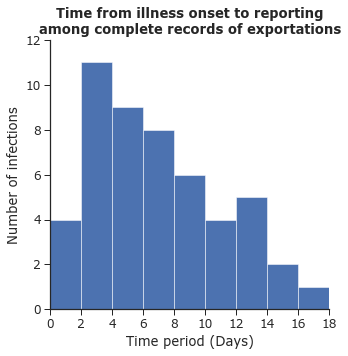

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5.5); 

bins_number = (max(df_onset2report.dist.values)+2)/2
n, edges = np.histogram(df_onset2report.dist.values, bins=10, range=(0,20), density=False)
timepoints = edges[:-1]
ymax = int(max(n))+1

ax.bar(timepoints, n, lw = 0.5, width = edges[1:]-edges[:-1], edgecolor = 'w', align='edge')
xstep = 2
xtks = edges[:-1]
ax.set_xlim(0,max(xtks))
ax.set_ylim(top=ymax)
ax.set_xticks(xtks)
ax.set_xticklabels([int(x) for x in xtks])
ax.set_xlabel('Time period (Days)'); ax.set_ylabel('Number of infections'); 
ax.set_title('Time from illness onset to reporting\namong complete records of exportations',fontweight='bold')
fig.autofmt_xdate(rotation=0,ha='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

INFO (theano.gof.compilelock): Waiting for existing lock by process '15870' (I am process '29914')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/aakhmetz/.theano/compiledir_Linux-5.5-arch1-1-x86_64-with-arch--3.7.3-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 156.2:   6%|▌         | 11693/200000 [00:02<00:46, 4028.73it/s] 
Convergence achieved at 12000
Interrupted at 11,999 [5%]: Average Loss = 261.48
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [b_delay, a_delay]
Sampling 10 chains, 0 divergences: 100%|██████████| 150000/150000 [00:36<00:00, 4115.57draws/s]
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_delay,6.572,0.643,5.370,7.857,0.002,0.002,74386.0,72482.0,76322.0,64400.0,1.0
sd_delay,4.523,0.620,3.396,5.756,0.004,0.003,27327.0,27027.0,27641.0,34973.0,1.0


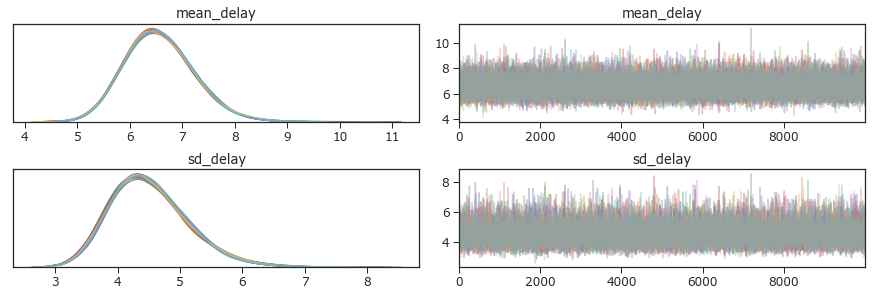

In [12]:
with pm.Model() as model_reporting_delay:
    a_delay = pm.HalfNormal('a_delay', sd=5)
    b_delay = pm.HalfCauchy('b_delay', 2.5)
    
    timeOnsetToDeath = df_onset2report.dist.values
    
    pm.Gamma('likelihood_delay', a_delay, b_delay, observed=timeOnsetToDeath)
    
    pm.Deterministic('mean_delay', a_delay/b_delay);
    pm.Deterministic('sd_delay', np.sqrt(a_delay)/b_delay);
    
    trace = pm.sample(10000, tune=5000, cores=10, target_accept=.9, init='advi')
    
vars_ = ['mean_delay', 'sd_delay']
pm.traceplot(trace, var_names=vars_)
pm.summary(trace, var_names=vars_, credible_interval=.95)

In [13]:
res_delay = pm.summary(trace, var_names=['a_delay', 'b_delay', 'mean_delay'])['mean']
res_delay

a_delay       2.165
b_delay       0.333
mean_delay    6.572
Name: mean, dtype: float64

# Main model

In [15]:
start = theano.shared(0.)
stop = theano.shared(250.)
μ = theano.shared(2.838)
σ = theano.shared(0.520)

inci_idx = np.min(df.loc[lambda d: d.exports>0].index)
inci_tmin = df.loc[inci_idx,'time']
len_p = len(df.loc[lambda d: d['time']>=inci_tmin,'prob_travel'])
death_idx = np.min(df.loc[lambda d: d['deaths']>0].index)
T0 = df['time'].values[inci_idx]
with pm.Model() as model:  
    ## main data and priors ##
    K = df['exports'].shape[0]
    exported_cases = df['exports'].values
    p = df.loc[0,'prob_travel']
    
    neglogr = pm.HalfNormal('neglogr', testval=-np.log(0.1))
    r = pm.Deterministic('r',np.exp(-neglogr))
    logi0 = pm.HalfNormal('logi0', sd=np.log(1000), testval=np.log(500))
    i0 = pm.Deterministic('i0', tt.exp(logi0))
    t = tt.arange(1,K+1,1)
    Incidence = pm.Deterministic('Incidence',i0*(tt.exp(r*(t-T0))-tt.exp(-r*T0))/r)
    
    ## implementing numerical integration 
    s = tt.dscalar('s')
    s.tag.test_value = np.zeros(()) #variable of integration
    r_ = tt.dscalar('r_')
    r_.tag.test_value = np.ones(())*0.14
    func = tt.exp(-r_*s)/s/σ/((2.0*np.pi)**0.5)*tt.exp(-((tt.log(s)-μ)**2)/2/(σ**2))
    integrate = Integrate(func, s, r_)
    
    ## calculating us ##
    u_delay = pm.Deterministic('u_delay', (1 + r*res_delay['mean_delay']/res_delay['a_delay'])**(-res_delay['a_delay']))
    u_death = pm.Deterministic('u_death', integrate(start, stop, r))
    ##############################
    
    ## reconstructed incidence from exportation events ##
    mu = (u_delay*Incidence*p/(1-p))[inci_idx:K]
    alpha = (1.0/(1-p))
    pm.Gamma('likelihood_incidence', mu, alpha, shape=K-inci_idx, 
             observed=exported_cases[inci_idx:K])
    ##############################
    
    ## CFR ##
    death = df['deaths'].values
    neglogq = pm.Gamma('neglogq', 2, .5, shape=K-death_idx, testval=-np.log(.06))
    q = pm.Deterministic('q',np.exp(-neglogq))
    
    shape_death = u_death*Incidence[death_idx:K]*q/(1-q)
    invscale_death = 1.0/(1-q)
    pm.Gamma('likelihood_death', shape_death, invscale_death, observed=death[death_idx:K])
    ##############################
    
    pm.Deterministic('predictedDeath', u_death*
                     Incidence[death_idx:K]*q)
    
    sample = pm.sample(4250, cores=8, tune=2500, target_accept=.92, init='advi')
    
pm.summary(sample, credible_interval=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 1,039.8:   4%|▍         | 8787/200000 [00:53<19:24, 164.25it/s]   
Convergence achieved at 8800
Interrupted at 8,799 [4%]: Average Loss = 2.9626e+25
INFO (theano.gof.compilelock): Refreshing lock /home/aakhmetz/.theano/compiledir_Linux-5.5-arch1-1-x86_64-with-arch--3.7.3-64/lock_dir/lock
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [neglogq, logi0, neglogr]
Sampling 8 chains, 0 divergences: 100%|██████████| 54000/54000 [1:28:35<00:00, 10.16draws/s]
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
neglogr,1.240,0.123,1.005,1.483,0.001,0.001,7499.0,7499.0,7301.0,12756.0,1.0
r,0.291,0.035,0.221,0.358,0.000,0.000,7316.0,7199.0,7301.0,12756.0,1.0
logi0,5.388,0.125,5.142,5.630,0.001,0.001,17492.0,17492.0,17706.0,23983.0,1.0
i0,220.542,27.258,165.385,272.343,0.204,0.144,17869.0,17869.0,17706.0,23983.0,1.0
Incidence[0],0.016,0.029,0.000,0.058,0.000,0.000,11796.0,11796.0,7091.0,11910.0,1.0
Incidence[1],0.036,0.063,0.000,0.131,0.001,0.000,11649.0,11649.0,7089.0,11956.0,1.0
Incidence[2],0.062,0.106,0.000,0.224,0.001,0.001,11496.0,11496.0,7086.0,11956.0,1.0
Incidence[3],0.095,0.158,0.000,0.341,0.001,0.001,11338.0,11338.0,7084.0,11945.0,1.0
Incidence[4],0.138,0.221,0.001,0.487,0.002,0.001,11175.0,11175.0,7080.0,11924.0,1.0
Incidence[5],0.193,0.299,0.001,0.673,0.003,0.002,11008.0,11008.0,7077.0,11899.0,1.0


In [18]:
pm.summary(sample, credible_interval=0.95, var_names=['u_delay', 'u_death', 'r'])

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
u_delay,0.256,0.032,0.198,0.321,0.0,0.0,7602.0,7602.0,7301.0,12756.0,1.0
r,0.291,0.035,0.221,0.358,0.0,0.0,7316.0,7199.0,7301.0,12756.0,1.0


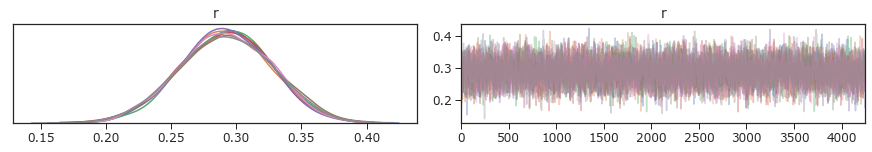

In [19]:
pm.traceplot(sample, var_names=['r']);

# Saving the results

In [20]:
!mkdir -p ../../results/Scenario-2

In [21]:
df_res = az.summary(sample, var_names=['r','Incidence','q','u_delay','predictedDeath'], stat_funcs=func_dict, extend=False, round_to=6).reset_index().rename(columns={'index': 'var'})
df_res['time'] = df_res['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
df_res['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(df_res['time'],df_res['var'])]
df_res['var'] = df_res['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
df_res.loc[lambda d: d['var']=='q', 'var'] = 'CFR'
df_res.rename(columns={'q2.5': 'lower', 'q97.5': 'upper'}).loc[:,['var','time','mean','lower','upper']].to_csv('../../results/Scenario-2/incidence-final.csv', index=False)

In [22]:
df_res

,var,mean,q2.5,q97.5,time
0,r,0.291416,0.221776,0.359277,NA
1,Incidence,0.015733,0.000573,0.085115,1
2,Incidence,0.035902,0.001391,0.191618,2
3,Incidence,0.061791,0.002564,0.325185,3
4,Incidence,0.095060,0.004236,0.491627,4
5,Incidence,0.137865,0.006623,0.700230,5
6,Incidence,0.193003,0.010044,0.959062,6
7,Incidence,0.264114,0.014933,1.284998,7
8,Incidence,0.355933,0.021941,1.689636,8
9,Incidence,0.474633,0.031982,2.194669,9
